In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from umap import UMAP
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

/home/juanjo/miniconda3/envs/egemaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Selección de variables

In [13]:
df = pd.read_csv("egemaps_LA.csv")
labels = pd.read_csv("/home/juanjo/Documentos/eGeMAPS_embedding/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt", 
                     sep=' ', header=None, names=["h1", "audio", "h2", "h3", "label"])
labels = labels.filter(items=["audio", "label"])

# le quitamos el .flac a los nombres de los audios
df["audio"] = df["audio"].apply(lambda x: x.replace(".flac", ""))

df = pd.merge(df, labels, on="audio")
df.drop(labels=["Unnamed: 0"], axis=1)
# 
df.head()

,Unnamed: 0,audio,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,label
0,0,LA_T_9054834,22.778221,0.098499,21.302931,22.475891,24.721390,3.418459,100.164154,105.332596,...,0.011031,0.175287,3.559871,1.644737,0.172000,0.178146,0.345000,0.414035,-17.783484,spoof
1,1,LA_T_6980436,28.998428,0.088787,27.743202,29.003092,30.589899,2.846697,136.143051,166.834427,...,0.000337,0.405845,5.720339,4.077253,0.095789,0.066989,0.135000,0.103401,-17.886377,spoof
2,2,LA_T_2117042,32.400963,0.143300,30.407715,34.263645,35.941391,5.533676,138.879913,87.293884,...,0.023323,0.097204,3.652968,2.803739,0.200000,0.145373,0.115714,0.102240,-18.018290,spoof
3,3,LA_T_2547007,35.747711,0.068483,34.369492,36.317474,37.616093,3.246601,215.282730,219.830231,...,0.008957,0.093073,1.825558,1.229508,0.140000,0.091469,0.558571,0.743187,-20.248434,bonafide
4,4,LA_T_1715181,34.141598,0.159520,32.097713,33.297329,34.005608,1.907894,200.921494,239.583771,...,0.007199,0.230671,4.347826,3.555556,0.141250,0.139144,0.153333,0.173461,-19.660992,spoof


In [11]:
df.columns

Index(['Unnamed: 0', 'audio', 'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sm

In [17]:
df_train = pd.read_csv("egemaps_LA_train_labeled.csv")
y_train = df_train["label"]
x_train = df_train.drop(columns=["label", "audio", "Unnamed: 0", "Unnamed: 0.1"])

selector = SelectKBest(score_func=f_classif, k = 40)
selector.fit(x_train, y_train)

selected_columns = x_train.columns[selector.get_support()]
print(selected_columns)
#x_new = SelectKBest(f_classif, k=20).fit_transform(x, y)
#x_new = pd.DataFrame(x_new, columns=x.columns)

Index(['F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_stddevFallingSlope',
       'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm',
       'mfcc1_sma3_amean', 'mfcc3_sma3_amean', 'mfcc4_sma3_amean',
       'jitterLocal_sma3nz_stddevNorm', 'shimmerLocaldB_sma3nz_amean',
       'shimmerLocaldB_sma3nz_stddevNorm', 'F1bandwidth_sma3nz_stddevNorm',
       'F1amplitudeLogRelF0_sma3nz_amean',
       'F1amplitudeLogRelF0_sma3nz_stddevNorm',
       'F2frequency_sma3nz_stddevNorm', 'F2bandwidth_sma3nz_stddevNorm',
       'F2amplitudeLogRelF0_sma3nz_amean',
       'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'F3bandwidth_sma3nz_amean',
       'F3amplitudeLogRelF0_sma3nz_amean',
       'F3amplitudeLogRelF0_sma3nz_stddevNorm',
       

## Subsampling

In [18]:
us = NearMiss(sampling_strategy="majority", n_neighbors=5, version=2)
x_res, y_res = us.fit_resample(x_train, y_train)

print("Distribucion de antes del resamlping: ", str(Counter(y)))
print("Distribucion despues del resampling: ", str(Counter(y_res)))

Distribucion de antes del resamlping:  Counter({'spoof': 22800, 'bonafide': 2580})
Distribucion despues del resampling:  Counter({0: 2580, 1: 2580})


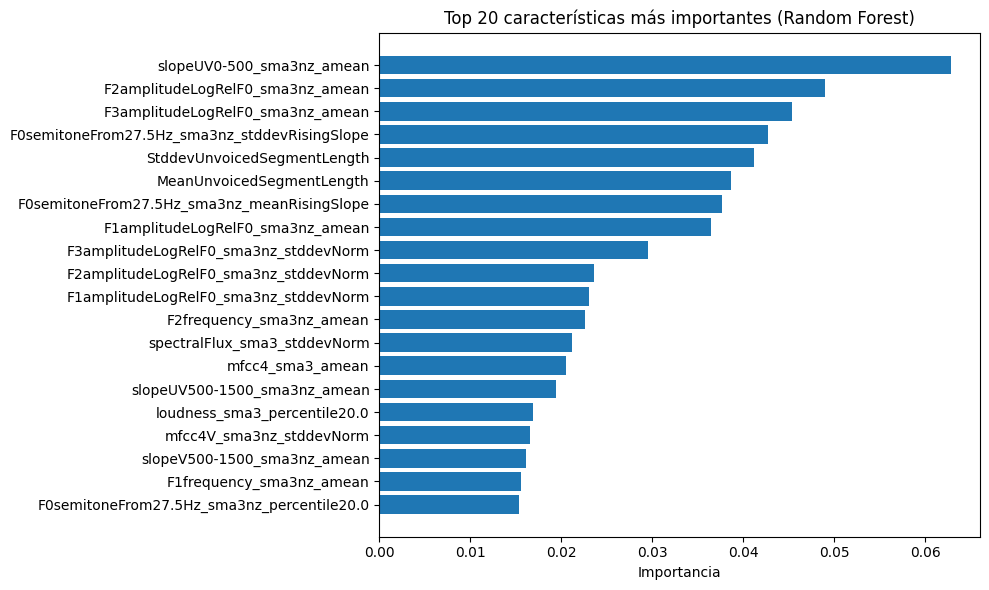

In [19]:
# ajustamos el modelo
model = RandomForestClassifier(n_estimators=500)
model.fit(x_res, y_res)

# Importancias
importances = model.feature_importances_
feature_names = np.array(x_res.columns)

# ordenamos de mayor a menor segun la imporaancia
indices = np.argsort(importances)[::-1][:20]

# graficamos
plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[indices][::-1])  # invertido para que el mayor esté arriba
plt.yticks(range(20), feature_names[indices][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 características más importantes (Random Forest)")
plt.tight_layout()
plt.show()

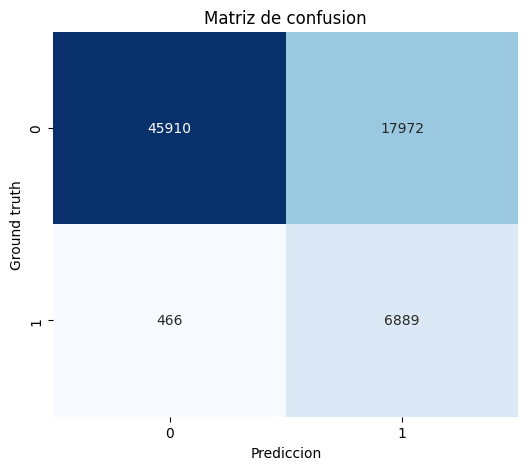

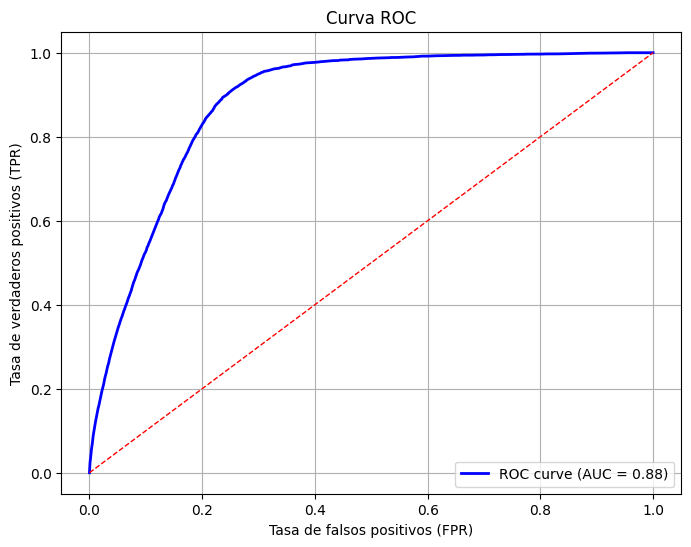

accuracy:  0.7411738282072519 EER:  (np.float64(0.1914928912418846), np.float64(0.684)) AUC:  0.8835249978977427
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     63882
           1       0.28      0.94      0.43      7355

    accuracy                           0.74     71237
   macro avg       0.63      0.83      0.63     71237
weighted avg       0.92      0.74      0.79     71237



<Figure size 640x480 with 0 Axes>

In [21]:
# evaluamos el modelo
df_eval = pd.read_csv("egemaps_LA_eval_labeled.csv")
y_eval = df_eval["label"]
x_eval = df_eval.drop(columns=["label", "audio", "Unnamed: 0", "Unnamed: 0.1"])
y_pred = model.predict(x_eval)
y_scores = [tup[1] for tup in model.predict_proba(x_eval)]

# evaluamos el modelo
import metrics
# compute accuracy and confusion matrix
acc, m = metrics.evaluate_model(y_true=y_eval, y_pred=y_pred)
eer = metrics.compute_eer(y_true=y_eval, y_scores=y_scores)
roc_auc, mas_cosas = metrics.plot_roc_curve(y_true=y_eval.values, y_scores=y_scores)

print("accuracy: ", acc, "EER: ", eer, "AUC: ", roc_auc)
print(classification_report(y_eval, y_pred))

## Balanceando los errores con pesos

In [ ]:
y = df["label"]
x = df.drop(columns=["label", "audio"])
model = RandomForestClassifier(class_weight="balanced")
model.fit(x, y)

importances = model.feature_importances_

plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), x.columns)
plt.xlabel("Importancia")
plt.title("Importancia de características")

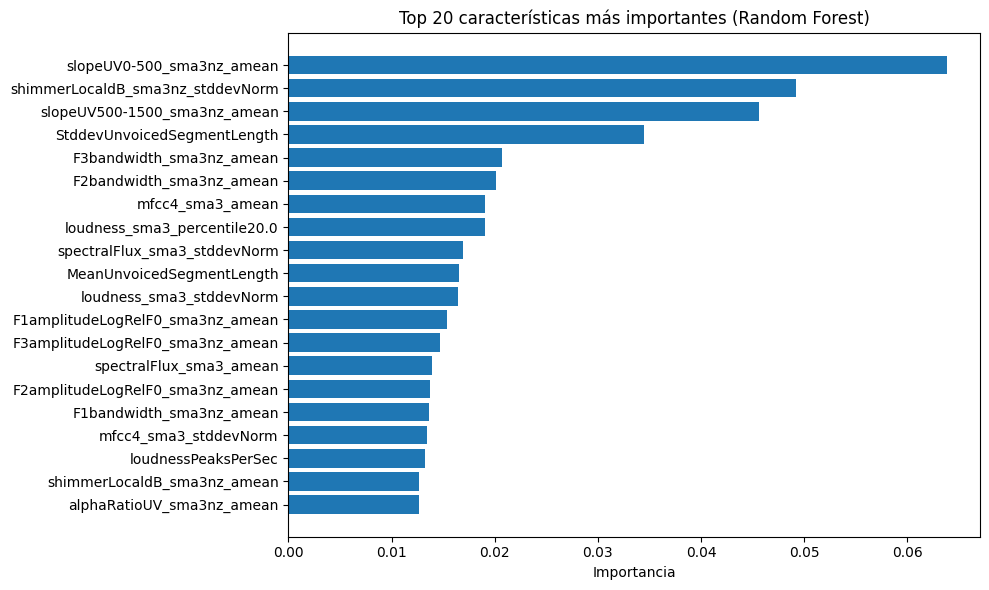

In [22]:
# Entrenamiento
y_train = df_train["label"]
x_train = df_train.drop(columns=["label", "audio", "Unnamed: 0", "Unnamed: 0.1"])
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train, y_train)

# Importancias
importances = model.feature_importances_
feature_names = np.array(x_train.columns)

# ordenamos de mayor a menor segun la imporaancia
indices = np.argsort(importances)[::-1][:20]

# graficamos
plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[indices][::-1])  # invertido para que el mayor esté arriba
plt.yticks(range(20), feature_names[indices][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 características más importantes (Random Forest)")
plt.tight_layout()
plt.show()



Sacamos la accuracy y la matriz de confusión del random forest que nos hemos montado con el conjunto de evaluación de LA, a ver qué nos sale.

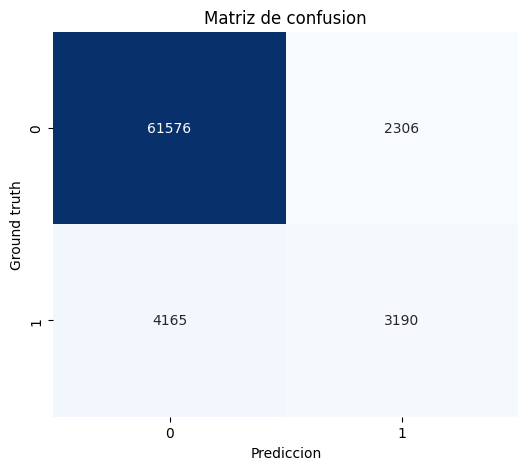

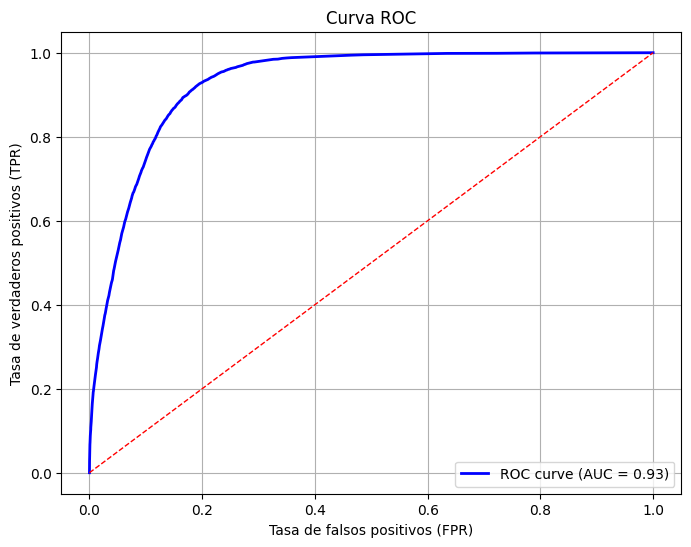

accuracy:  0.9091623734856886 EER:  (np.float64(0.14378626074489692), np.float64(0.264)) AUC:  0.9284827623738883


<Figure size 640x480 with 0 Axes>

In [23]:
df_eval = pd.read_csv("egemaps_LA_eval_labeled.csv")
y_eval = df_eval["label"]
x_eval = df_eval.drop(columns=["label", "audio", "Unnamed: 0", "Unnamed: 0.1"])
y_pred = model.predict(x_eval)
y_scores = [tup[1] for tup in model.predict_proba(x_eval)]

# evaluamos el modelo
import metrics
# compute accuracy and confusion matrix
acc, m = metrics.evaluate_model(y_true=y_eval, y_pred=y_pred)
eer = metrics.compute_eer(y_true=y_eval, y_scores=y_scores)
roc_auc, mas_cosas = metrics.plot_roc_curve(y_true=y_eval.values, y_scores=y_scores)

print("accuracy: ", acc, "EER: ", eer, "AUC: ", roc_auc)

In [24]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     63882
           1       0.58      0.43      0.50      7355

    accuracy                           0.91     71237
   macro avg       0.76      0.70      0.72     71237
weighted avg       0.90      0.91      0.90     71237



Text(0, 0.5, 'Frequency')

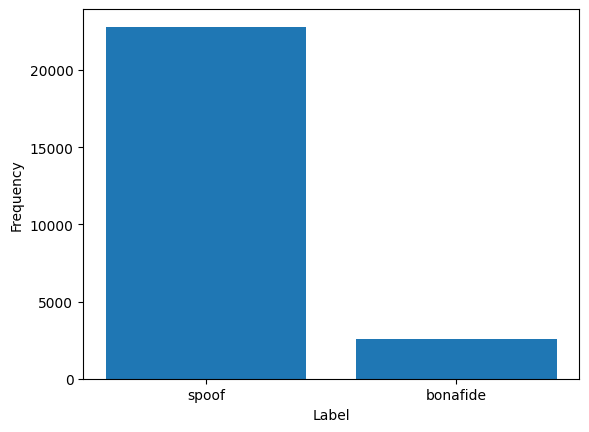

In [25]:
# numero de audios que son spoof y los que son naturales
y_train[y_train == "spoof"]
y_train[y_train == "bonafide"]
count = Counter(y_train)

plt.bar(["spoof", "bonafide"], list(count.values()))
plt.xlabel("Label")
plt.ylabel("Frequency")


In [19]:
y_eval

0        1
1        0
2        0
3        0
4        1
        ..
71232    0
71233    0
71234    0
71235    0
71236    0
Name: label, Length: 71237, dtype: int64

Text(0, 0.5, 'Frequency')

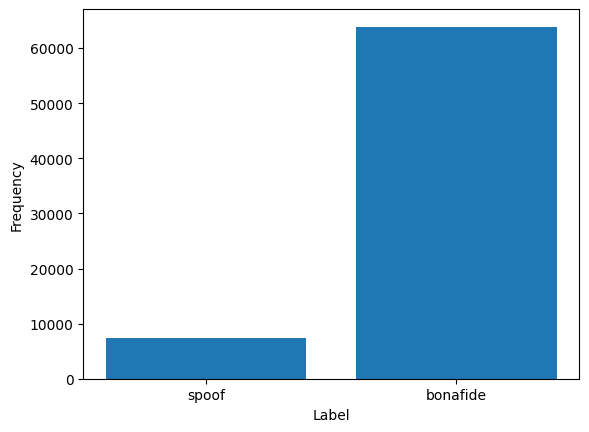

In [26]:
count = Counter(y_eval)

plt.bar(["spoof", "bonafide"], list(count.values()))
plt.xlabel("Label")
plt.ylabel("Frequency")

## SMOTETomek

In [28]:
os_us = SMOTETomek(sampling_strategy="all", random_state=3)
x_train_res, y_train_res = os_us.fit_resample(x_train, y_train)

print("Dsitribucion antes del resampling: ", str(Counter(y_train)))
print("Distribucion despues del resampling: ", str(Counter(y_train_res)))

Dsitribucion antes del resampling:  Counter({0: 22800, 1: 2580})
Distribucion despues del resampling:  Counter({0: 22767, 1: 22767})


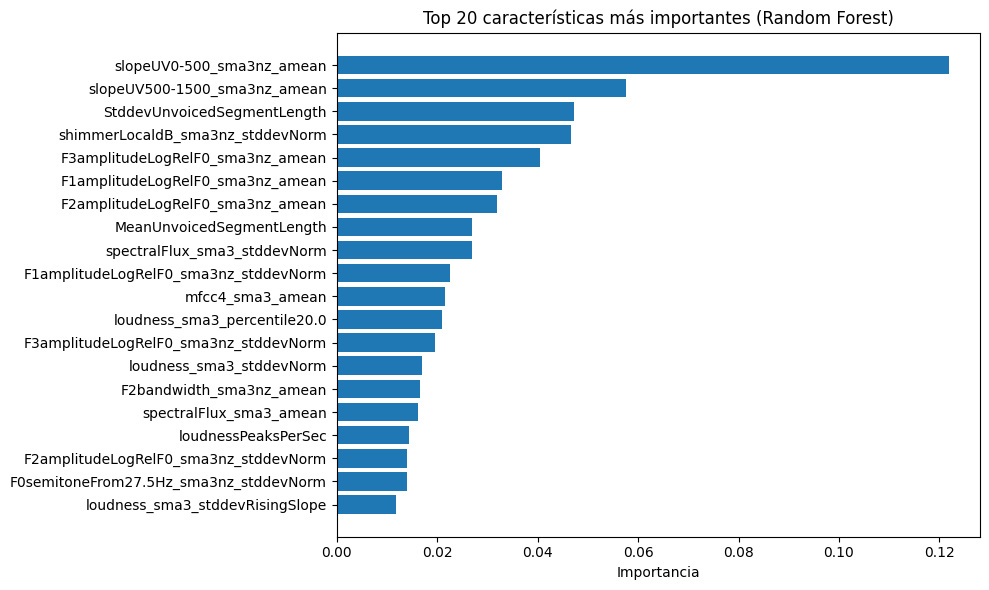

In [29]:
# ajustamos el modelo
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train_res, y_train_res)

# Importancias
importances = model.feature_importances_
feature_names = np.array(x_train_res.columns)

# ordenamos de mayor a menor segun la imporaancia
indices = np.argsort(importances)[::-1][:20]

# graficamos
plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[indices][::-1])  # invertido para que el mayor esté arriba
plt.yticks(range(20), feature_names[indices][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 características más importantes (Random Forest)")
plt.tight_layout()
plt.show()

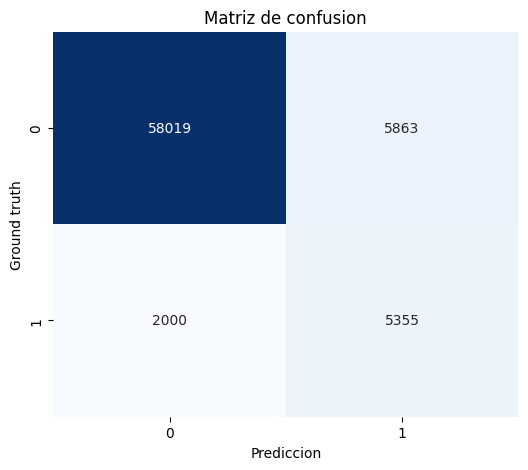

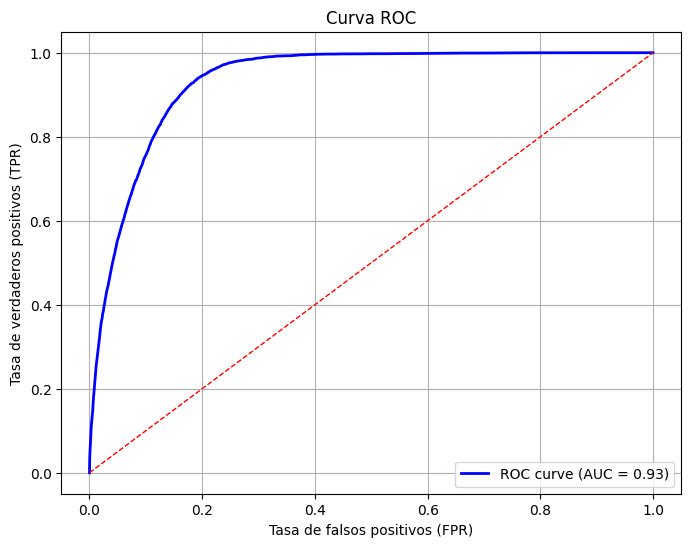

accuracy:  0.8896219661131154 EER:  (np.float64(0.13888823123514332), np.float64(0.392)) AUC:  0.9341058764214126
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     63882
           1       0.48      0.73      0.58      7355

    accuracy                           0.89     71237
   macro avg       0.72      0.82      0.76     71237
weighted avg       0.92      0.89      0.90     71237



<Figure size 640x480 with 0 Axes>

In [30]:
# evaluamos el modelo
df_eval = pd.read_csv("egemaps_LA_eval_labeled.csv")
y_eval = df_eval["label"]
x_eval = df_eval.drop(columns=["label", "audio", "Unnamed: 0", "Unnamed: 0.1"])
y_pred = model.predict(x_eval)
y_scores = [tup[1] for tup in model.predict_proba(x_eval)]

# evaluamos el modelo
import metrics
# compute accuracy and confusion matrix
acc, m = metrics.evaluate_model(y_true=y_eval, y_pred=y_pred)
eer = metrics.compute_eer(y_true=y_eval, y_scores=y_scores)
roc_auc, mas_cosas = metrics.plot_roc_curve(y_true=y_eval.values, y_scores=y_scores)

print("accuracy: ", acc, "EER: ", eer, "AUC: ", roc_auc)
print(classification_report(y_eval, y_pred))

## UMAP

/home/juanjo/miniconda3/envs/egemaps/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/juanjo/miniconda3/envs/egemaps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


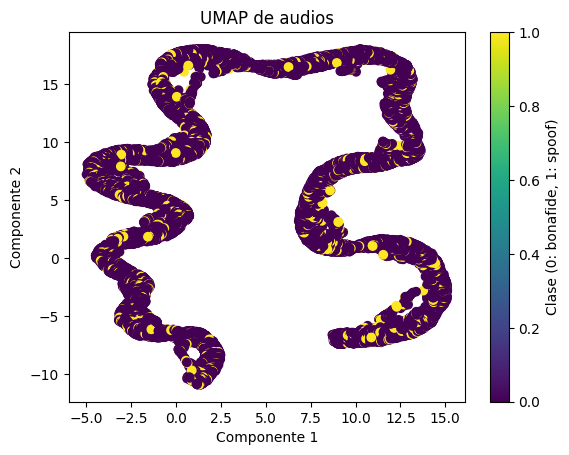

In [7]:
y = df["label"]
x = df.drop(columns=["label", "audio"])

umap = UMAP(n_components=2, random_state=42)
x_umap = umap.fit_transform(x)

plt.scatter(x_umap[:, 0], x_umap[:, 1], c=y.map({'bonafide':1, 'spoof': 0}))
plt.title("UMAP de audios")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label='Clase (0: bonafide, 1: spoof)')
plt.show()